# Bulldozers

##### This notebook contains the solution of the Kaggle problem - Blue book for bulldozers

##### The problem can be found here: https://www.kaggle.com/c/bluebook-for-bulldozers

## Load dependencies

In [56]:
%matplotlib inline

import sys
sys.path.append('/home/sarfraz/fastai')

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.tree import _tree

import warnings
warnings.filterwarnings('ignore')

In [57]:
set_plot_sizes(12, 14, 16)

## Load data

In [3]:
PATH = "data/bulldozers/"

df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

In [4]:
df_raw.head(5).transpose()

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


##### Since our evaluation metric is RMSLE (Root Mean Squared Log Error) we should be using the log of the target variable

In [5]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Treating data

In [7]:
add_datepart(df_raw, 'saledate') # Add individual date-associated columns by splitting the date feature
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [9]:
train_cats(df_raw) # Change the columns containing strings to categorical columns containing codes

In [10]:
df_raw.UsageBand.cat.categories 

Index(['High', 'Low', 'Medium'], dtype='object')

In [11]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True) # Change the sequence of ordinal category

In [13]:
df_raw.UsageBand.cat.codes

0         2
1         2
2         0
3         0
4         1
5         2
6         0
7         0
8         2
9         1
10        1
11        2
12       -1
13        1
14        2
15        1
16        2
17       -1
18        2
19        1
20        1
21        1
22        2
23        0
24        1
25        1
26        2
27       -1
28        2
29        1
         ..
401095   -1
401096   -1
401097   -1
401098   -1
401099   -1
401100   -1
401101   -1
401102   -1
401103   -1
401104   -1
401105   -1
401106   -1
401107   -1
401108   -1
401109   -1
401110   -1
401111   -1
401112   -1
401113   -1
401114   -1
401115   -1
401116   -1
401117   -1
401118   -1
401119   -1
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [16]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [17]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

## Reading from the feather format

In [58]:
df_raw = pd.read_feather('tmp/raw')

### Processing dataframe

In [59]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [60]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

## Base Model

In [61]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.983132931931765

##### Very high accuracy often leads to an overfit model and so to ensure that our model is not overfitting we need to have a separate dataset on which we can test our model

#### Splitting data into training and validation datasets

In [62]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

##### Let's try our model again, but this time with separate training and validation sets

In [63]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [64]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 55s, sys: 351 ms, total: 1min 55s
Wall time: 33.4 s
[0.09069038562257527, 0.25164793033815674, 0.9828107343580746, 0.8869072668776731]


## Speeding things up

In [65]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [66]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4.18 s, sys: 19.8 ms, total: 4.2 s
Wall time: 1.29 s
[0.11166000465681497, 0.3494380849256312, 0.9731445729772042, 0.7819337540774677]


## Single tree

In [67]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5296410668146961, 0.5797507359750115, 0.39577306322812267, 0.3997521802664592]


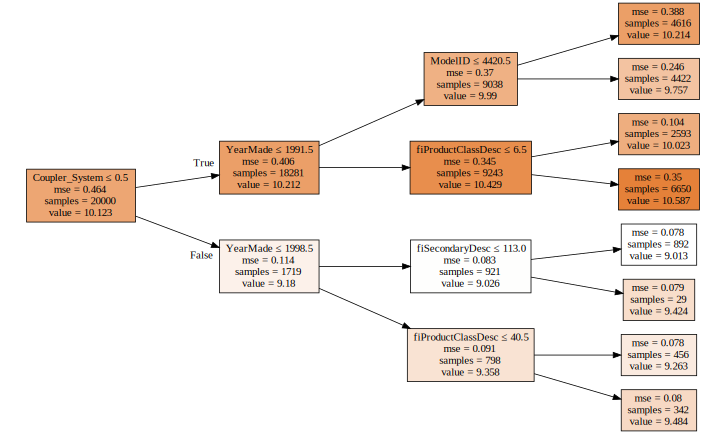

In [68]:
draw_tree(m.estimators_[0], df_trn, precision=3)

## Out-of-Bag in action

In [83]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09679682039196345, 0.33388897589037503, 0.979818243470699, 0.8009087679801589, 0.8564681543683518]


## Optimizing hyperparameters

In [84]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1446669697754061, 0.33586990848588544, 0.9549208676355175, 0.7985393801392169, 0.8573383667994646]
